# A machine learning decision tree approach

The iMeta algorithm is essentially a decision tree algorithm, where the variables and threshold for the decisions at each step are manually specified based on human analysis. The simplest way to apply machine learning techniques to the problem would be 

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [3]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [4]:
from xbt_dataset import XbtDataset

In [5]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [6]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/annual_csv',
    'pangeo': '/data/misc/xbt-data/annual_csv/',
}
env_date_ranges = {
    'MO_scitools': (1996,2015),
    'pangeo': (1966,2015)
}

In [7]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year']

In [8]:
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

In [9]:
xbt_labelled = xbt_full_dataset.filter_obs('labelled', 'labelled')

extracting labelled


In [129]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [10]:
(ml_ds, ml_encoders, ml_features, column_indices) = xbt_labelled.filter_features(input_feature_names).get_ml_dataset()
(ml_model, model_encoders, _, _) = xbt_labelled.filter_features(['model']).get_ml_dataset()
(ml_manuf, manuf_encoders, _, _) = xbt_labelled.filter_features(['manufacturer']).get_ml_dataset()
X_train_model, X_test_model, y_train_model, y_test_model = sklearn.model_selection.train_test_split(ml_ds, ml_model)
X_train_manuf, X_test_manuf, y_train_manuf, y_test_manuf = sklearn.model_selection.train_test_split(ml_ds, ml_manuf)


In [11]:
clf_dt_model1 = sklearn.tree.DecisionTreeClassifier()
clf_dt_model1.fit(X_train_model,y_train_model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [40]:
y_res_train_model = clf_dt_model1.predict(X_train_model)
metric_train_model_all = sklearn.metrics.precision_recall_fscore_support(y_train_model, y_res_train_model, )

In [41]:
y_res_test_model = clf_dt_model1.predict(X_test_model)
metric_test_model_all = sklearn.metrics.precision_recall_fscore_support(y_test_model, y_res_test_model,)

In [58]:
clf_dt_manuf1 = sklearn.tree.DecisionTreeClassifier()
clf_dt_manuf1.fit(X_train_manuf,y_train_manuf)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [64]:
y_res_train_manuf = clf_dt_manuf1.predict(X_train_manuf)
metric_train_manuf_all = sklearn.metrics.precision_recall_fscore_support(y_train_manuf, y_res_train_manuf, )


In [100]:
y_res_test_manuf = clf_dt_manuf1.predict(X_test_manuf)
metric_test_manuf_all = sklearn.metrics.precision_recall_fscore_support(y_test_manuf, y_res_test_manuf, )

In [88]:
metric_model_all_df = pandas.DataFrame.from_dict({
    'model': model_encoders['model'].categories_[0],
    'precision_train': metric_train_model_all[0],
    'precision_test': metric_test_model_all[0],
    'recall_train': metric_train_model_all[1],
    'recall_test': metric_test_model_all[1],
    'f1_train': metric_train_model_all[2],
    'f1_test': metric_test_model_all[2],
    'support_train': metric_train_model_all[3],
    'support_test': metric_test_model_all[3],
})

In [86]:
metric_manuf_all_df = pandas.DataFrame.from_dict({
    'manufacturer': manuf_encoders['manufacturer'].categories_[0],
    'precision_train': metric_train_manuf_all[0],
    'precision_test': metric_test_manuf_all[0],
    'recall_train': metric_train_manuf_all[1],
    'recall_test': metric_test_manuf_all[1],
    'f1_train': metric_train_manuf_all[2],
    'f1_test': metric_test_manuf_all[2],
    'support_train': metric_train_manuf_all[3],
    'support_test': metric_test_manuf_all[3],
})

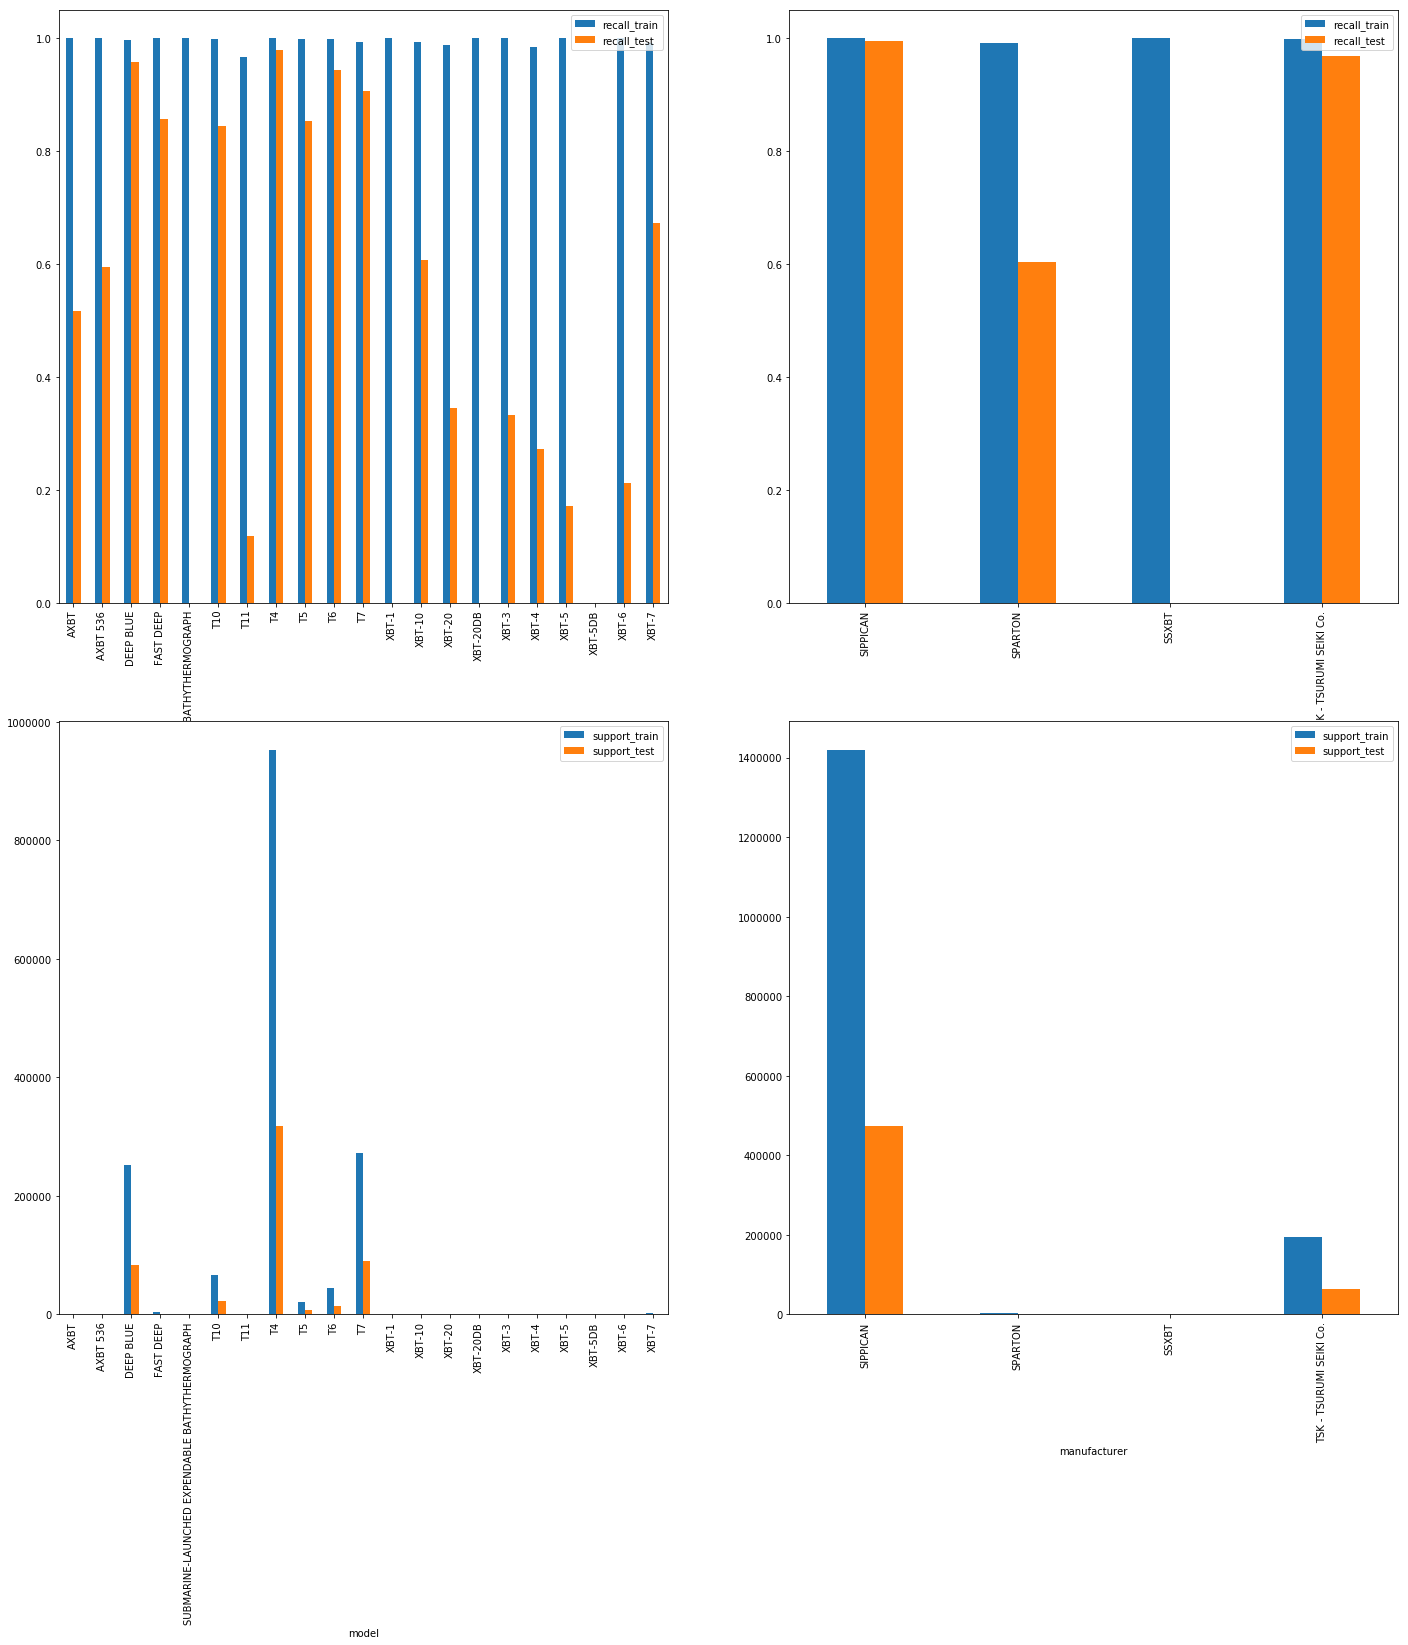

In [95]:
fig_results_all_dt = matplotlib.pyplot.figure('xbt_results_all_dt', figsize=(24,24))
axis_model_metrics = fig_results_all_dt.add_subplot(221)
_ = metric_model_all_df.plot.bar(x='model',y=['recall_train', 'recall_test'], ax=axis_model_metrics)
axis_manuf_metrics = fig_results_all_dt.add_subplot(222)
_ = metric_manuf_all_df.plot.bar(x='manufacturer', y=['recall_train','recall_test'],ax=axis_manuf_metrics)
axis_model_support = fig_results_all_dt.add_subplot(223)
_ = metric_model_all_df.plot.bar(x='model',y=['support_train', 'support_test'], ax=axis_model_support)
axis_manuf_support = fig_results_all_dt.add_subplot(224)
_ = metric_manuf_all_df.plot.bar(x='manufacturer',y=['support_train', 'support_test'], ax=axis_manuf_support)


In [102]:
metric_model_train_avg_all = sklearn.metrics.precision_recall_fscore_support(y_train_model, y_res_train_model, average='micro' )
metric_model_test_avg_all = sklearn.metrics.precision_recall_fscore_support(y_test_model, y_res_test_model, average='micro')
metric_manuf_train_avg_all = sklearn.metrics.precision_recall_fscore_support(y_train_manuf, y_res_train_manuf, average='micro' )
metric_manuf_test_avg_all = sklearn.metrics.precision_recall_fscore_support(y_test_manuf, y_res_test_manuf, average='micro')

(0.9906071844000972, 0.9901975328788767, 0.9904023162793372, None)

In [108]:
def select_year_data(X, y, year_encoder, year_array, selected_year):
    X_select = X[(year_encoder.inverse_transform(year_array.reshape(-1,1)) == selected_year).reshape(-1),:]
    y_select = y[(year_encoder.inverse_transform(year_array.reshape(-1,1)) == selected_year).reshape(-1),:]
    return (X_select, y_select)

def score_year(X, y, year, year_encoder, column_indices, clf):
    (X_year, y_year) = select_year_data(
        X, y , ml_encoders['year'], X[:,column_indices['year']].reshape(-1,1), year)
    y_res_year = clf.predict(X_year)
    metric_year = sklearn.metrics.precision_recall_fscore_support(
        y_year, y_res_year, average='micro')
    return metric_year

In [113]:
results_by_year = {}

In [116]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    results_by_year[year] = {
        'metric_train_model' : score_year(X_train_model, y_train_model, year, ml_encoders['year'], column_indices, clf_dt_model1),
        'metric_test_model' : score_year(X_test_model, y_test_model, year, ml_encoders['year'], column_indices, clf_dt_model1),
        'metric_train_manuf' : score_year(X_train_manuf, y_train_manuf, year, ml_encoders['year'], column_indices, clf_dt_manuf1),
        'metric_test_manuf' : score_year(X_test_manuf, y_test_manuf, year, ml_encoders['year'], column_indices, clf_dt_manuf1),
    }


In [123]:
recall_by_year = pandas.DataFrame.from_dict({ 
    'year':  list(results_by_year.keys()),
    'recall_train_model' : [m1['metric_train_model'][1] for y1,m1 in results_by_year.items()],
    'recall_test_model' : [m1['metric_test_model'][1] for y1,m1 in results_by_year.items()],
    'recall_train_manuf' : [m1['metric_train_manuf'][1] for y1,m1 in results_by_year.items()],
    'recall_test_manuf' : [m1['metric_test_manuf'][1] for y1,m1 in results_by_year.items()],
})
    

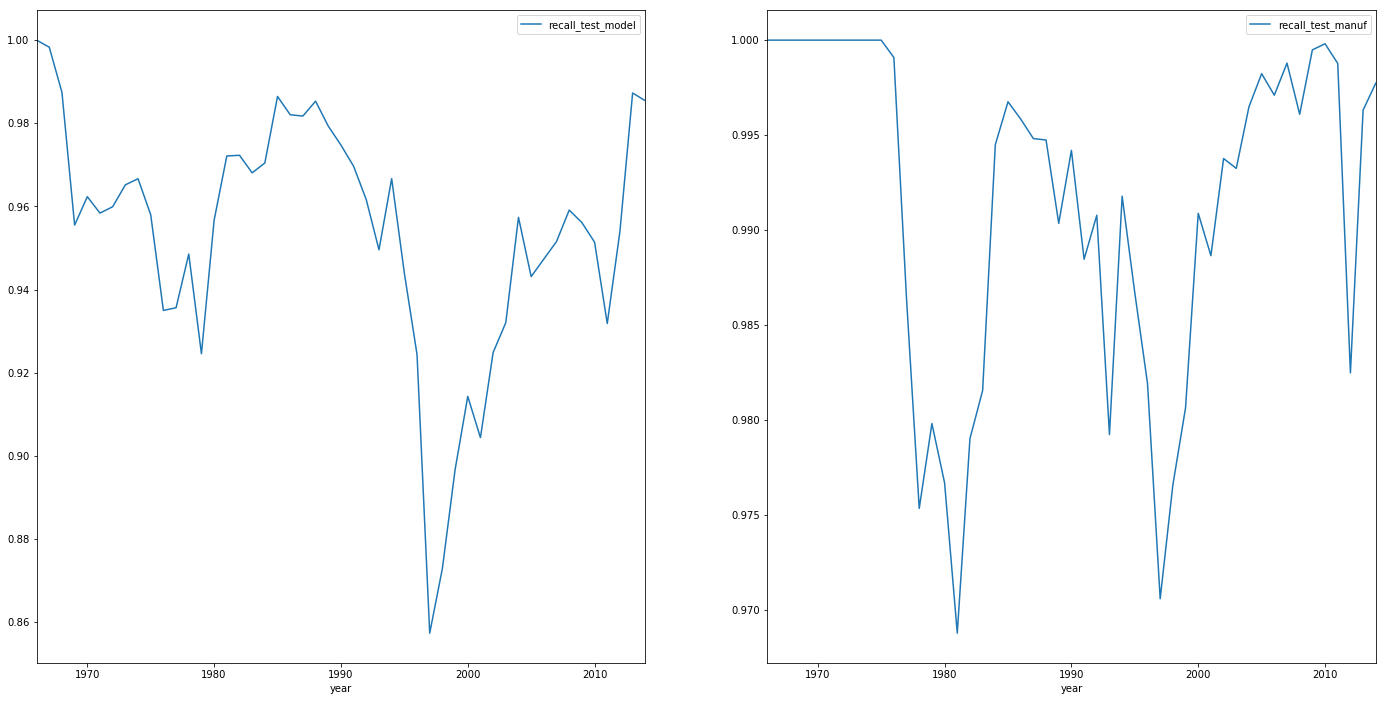

In [128]:
fig_metrics_by_year = matplotlib.pyplot.figure('metrics_by_year',figsize=(24,12))
axis_model_metrics_by_year = fig_metrics_by_year.add_subplot(121)
_ = recall_by_year.plot.line(x='year',y='recall_test_model',ax=axis_model_metrics_by_year)
axis_manuf_metrics_by_year = fig_metrics_by_year.add_subplot(122)
_ = recall_by_year.plot.line(x='year',y='recall_test_manuf',ax=axis_manuf_metrics_by_year)

In [154]:
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_model = model_encoders['model'].transform(pandas.DataFrame(imeta_model[xbt_labelled.xbt_df.year == year]))
    xbt_model1 = model_encoders['model'].transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].model))

    y_imeta_manuf = manuf_encoders['manufacturer'].transform(pandas.DataFrame(imeta_manufacturer[xbt_labelled.xbt_df.year == year]))
    xbt_manufacturer1 = manuf_encoders['manufacturer'].transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].manufacturer))
    
    y_imeta_model = model_encoders['model'].transform(pandas.DataFrame(imeta_model[xbt_labelled.xbt_df.year == year]))
    y_imeta_manuf = manuf_encoders['manufacturer'].transform(pandas.DataFrame(imeta_manufacturer[xbt_labelled.xbt_df.year == year]))
    
    (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = sklearn.metrics.precision_recall_fscore_support(xbt_model1, y_imeta_model,average='micro')
    (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = sklearn.metrics.precision_recall_fscore_support(xbt_manufacturer1, y_imeta_manuf,average='micro')

    imeta_results += [{'year': year,
                       'imeta_model_recall': im_rec_model,
                       'imeta_model_precision': im_pr_model,
                       'imeta_manuf_recall': im_rec_manuf,
                       'imeta_manuf_precision': im_pr_manuf,
                       
                      }]

In [155]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [158]:
results_df = pandas.merge(recall_by_year, imeta_res_df)

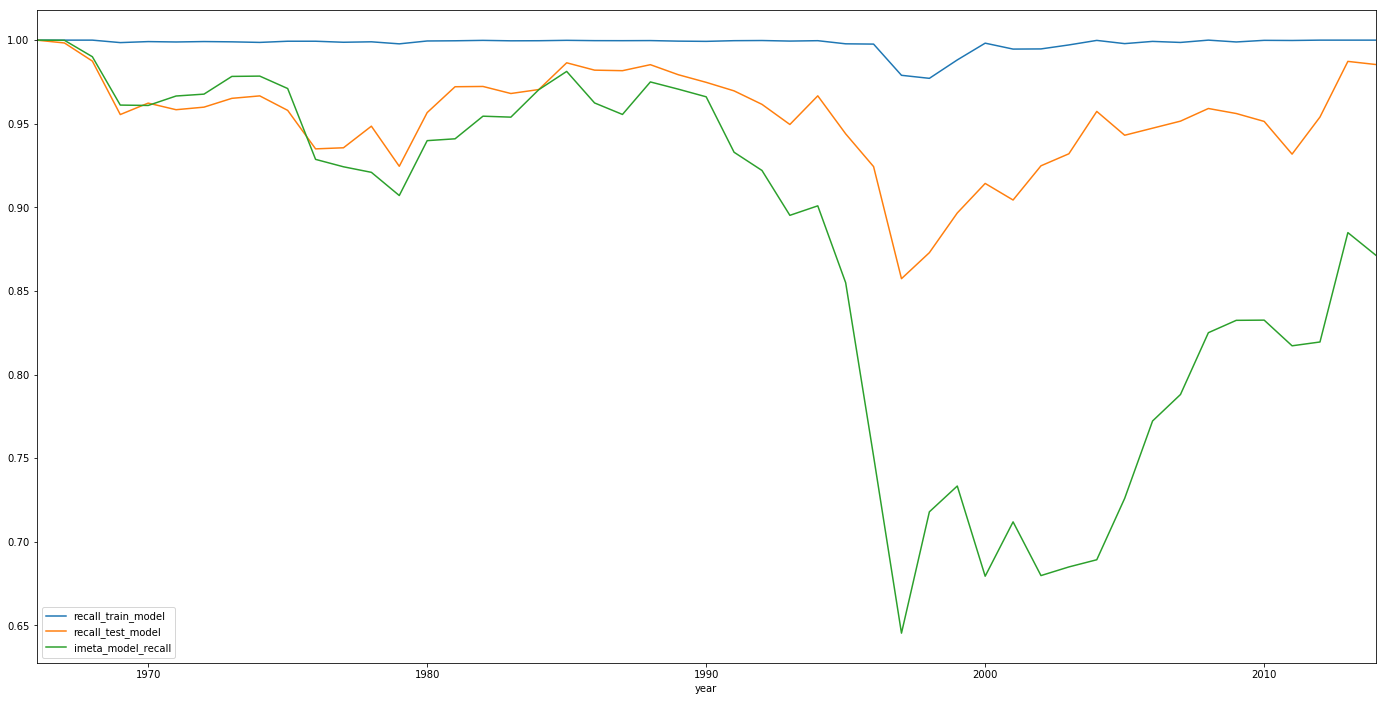

In [161]:
_ = results_df.plot.line(x='year',y=['recall_train_model','recall_test_model', 'imeta_model_recall'], figsize=(24,12))

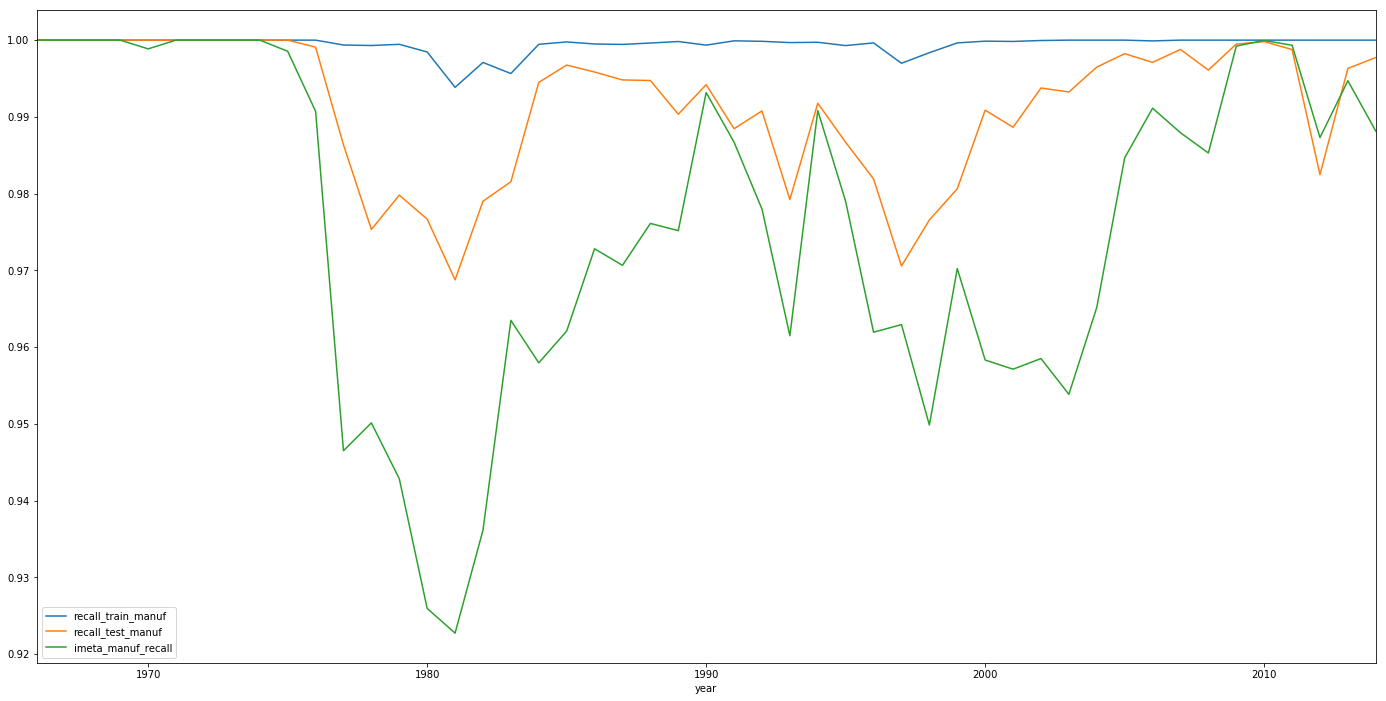

In [162]:
_ = results_df.plot.line(x='year',y=['recall_train_manuf','recall_test_manuf', 'imeta_manuf_recall'], figsize=(24,12))